In [131]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

In [132]:
inputFile = 'preprocessed_data.csv'
metaFile = 'meta.csv'

!rm -rf classify_wrapper/ classify_wrapper.zip IODetectorModel.tflite meta.json model.png

In [133]:
df = pd.read_csv(inputFile)
del df['FileName']
del df['timestamp']
target = df.loc[:,'INDOOR'].to_numpy()
del df['INDOOR']

df_meta = pd.read_csv(metaFile)

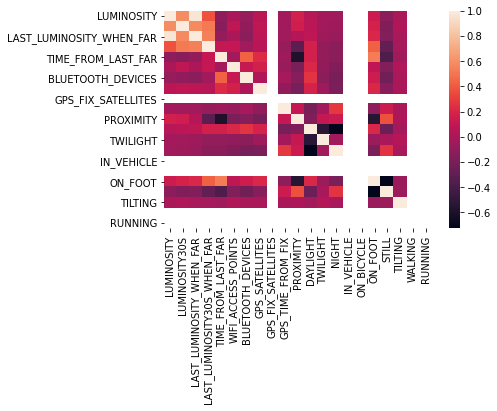

In [134]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr)

In [135]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), target, test_size=0.33) 
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7289, 21) (3591, 21) (7289,) (3591,)


In [136]:
D = X_train.shape[1]
D

21

In [137]:
# Now all the fun Tensorflow stuff
# Build the model

i = tf.keras.layers.Input(shape=(D,),name='Input')
x = tf.keras.layers.Dense(16,activation='sigmoid', name='Hidden')(i)
x = tf.keras.layers.Dense(1, activation='sigmoid', name='Classifier')(x)
model = tf.keras.models.Model(i, x)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

r = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=50)

print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/50
228/228 [==============================] - 1s 2ms/step - loss: 0.5830 - accuracy: 0.7903 - val_loss: 0.3690 - val_accuracy: 0.9488
Epoch 2/50
228/228 [==============================] - 0s 2ms/step - loss: 0.3178 - accuracy: 0.9553 - val_loss: 0.2154 - val_accuracy: 0.9571
Epoch 3/50
228/228 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.9544 - val_loss: 0.1606 - val_accuracy: 0.9577
Epoch 4/50
228/228 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.9587 - val_loss: 0.1371 - val_accuracy: 0.9574
Epoch 5/50
228/228 [==============================] - 0s 2ms/step - loss: 0.1298 - accuracy: 0.9572 - val_loss: 0.1244 - val_accuracy: 0.9549
Epoch 6/50
228/228 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9483 - val_loss: 0.1168 - val_accuracy: 0.9532
Epoch 7/50
228/228 [==============================] - 0s 2ms/step - loss: 0.1182 - accuracy: 0.9517 - val_loss: 0.1118 - val_accuracy: 0.9593
Epoch 

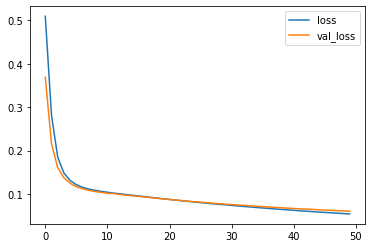

In [138]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

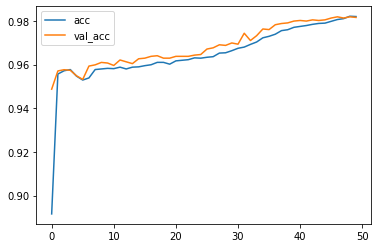

In [139]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [140]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 21)]              0         
_________________________________________________________________
Hidden (Dense)               (None, 16)                352       
_________________________________________________________________
Classifier (Dense)           (None, 1)                 17        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


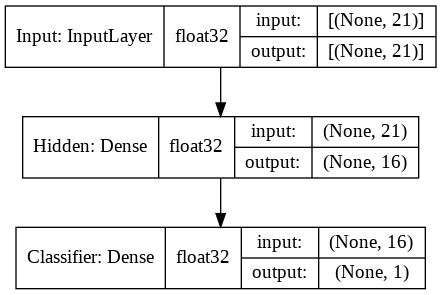

In [141]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True, show_layer_names=True, expand_nested=True)

In [142]:
!pip install tflite_support

In [143]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [144]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "IODetector model"
model_meta.description = "Detect if the user is indoor or outdoor."
model_meta.version = "v1"
model_meta.author = "Dario Lorenzoni, Niccolò Scatena"
model_meta.license = "MIT LICENSE"

In [145]:
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "feature_vector"
input_meta.description = "IODetection input vector"
input_meta.content = _metadata_fb.ContentT()
input_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
input_meta.content.contentPropertiesType = (_metadata_fb.ContentProperties.FeatureProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (_metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = df_meta.iloc[1, 1:].values.tolist()
input_normalization.options.std = df_meta.iloc[2, 1:].values.tolist()
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.min = df_meta.iloc[3, 1:].values.tolist()
input_stats.max = df_meta.iloc[7, 1:].values.tolist()
input_meta.stats = input_stats

In [146]:
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "IODetection"
output_meta.description = "Indoor/Outdoor label."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (_metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.min = [0.0]
output_stats.max = [1.0]
output_meta.stats = output_stats
#label_file = _metadata_fb.AssociatedFileT()
#label_file.name = os.path.basename("iomap.txt")
#label_file.description = "Labels for objects that the model can recognize."
#label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
#output_meta.associatedFiles = [label_file]

In [147]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [148]:
#tf.saved_model.save(model, "saved_model_keras_dir")

#converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
#converter.allow_custom_ops=True
#converter.experimental_new_converter =True

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('IODetectorModel.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpd3gdqj39/assets


INFO:tensorflow:Assets written to: /tmp/tmpd3gdqj39/assets


In [149]:
populator = _metadata.MetadataPopulator.with_model_file('IODetectorModel.tflite')
populator.load_metadata_buffer(metadata_buf)
#populator.load_associated_files(["iomap.txt"])
populator.populate()

In [150]:
displayer = _metadata.MetadataDisplayer.with_model_file('IODetectorModel.tflite')
export_json_file = "meta.json"
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
  f.write(json_file)

In [151]:
!tflite_codegen --model=./IODetectorModel.tflite \
    --package_name=it.unipi.dii.iodetectionlib.ml.generated \
    --model_class_name=IODetectorModel \
    --destination=./classify_wrapper

!zip -r classify_wrapper.zip classify_wrapper/

I0520 01:09:34.404804 139699109582720 codegen.py:88] Generation succeeded!
I0520 01:09:34.405288 139699109582720 codegen.py:93] Model copied into assets!
  adding: classify_wrapper/ (stored 0%)
  adding: classify_wrapper/src/ (stored 0%)
  adding: classify_wrapper/src/main/ (stored 0%)
  adding: classify_wrapper/src/main/java/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/iodetectionlib/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/iodetectionlib/ml/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/iodetectionlib/ml/generated/ (stored 0%)
  adding: classify_wrapper/src/main/java/it/unipi/dii/iodetectionlib/ml/generated/IODetectorModel.java (deflated 79%)
  adding: classify_wrapper/src/main/AndroidManifest.xml (deflated 24%)
  adding: classify_wr